In [2]:
import pandas as pd

In [3]:
dat_id = pd.read_csv('dataset/data_identification.csv')
labels = pd.read_csv('dataset/emotion.csv')
data = pd.read_json('dataset/tweets_DM.json', lines=True)

In [3]:
data.head()

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets


In [4]:
set(data._index)

{'hashtag_tweets'}

In [5]:
print(min(data._score))
print(max(data._score))

1
1024


In [6]:
texts = data["_source"].apply(lambda x: x["tweet"]["text"])
hashtags = data["_source"].apply(lambda x: x["tweet"]["hashtags"])

In [7]:
texts.head()

0    People who post "add me on #Snapchat" must be ...
1    @brianklaas As we see, Trump is dangerous to #...
2    Confident of your obedience, I write to you, k...
3                  Now ISSA is stalking Tasha 😂😂😂 <LH>
4    "Trust is not the same as faith. A friend is s...
Name: _source, dtype: object

## Text preprocessing

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

filtered_tokens = []
for text in texts:
    words = [word for word in text.split() if word.lower() not in stop_words] # remove '\n'
    filtered_tokens.extend([word for word in words if tokenizer.tokenize(word)])

print(filtered_tokens[:10])  # Display the first 10 tokens after processing

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yvonneh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['People', 'post', '"add', '#Snapchat"', 'must', 'dehydrated.', 'Cuz', 'man....', "that's", '<LH>']


In [9]:
# Remove '<LH>' from text
data["cleaned_text"] = texts.str.replace(r"<LH>", "", regex=True).str.strip()

# Filter for tweets with hashtags
df_with_hashtags = data[data["_source"].apply(lambda x: len(x["tweet"]["hashtags"]) > 0)]

print(df_with_hashtags)


         _score          _index  \
0           391  hashtag_tweets   
1           433  hashtag_tweets   
2           232  hashtag_tweets   
5           120  hashtag_tweets   
8           827  hashtag_tweets   
...         ...             ...   
1867520      66  hashtag_tweets   
1867526      94  hashtag_tweets   
1867528     274  hashtag_tweets   
1867530     827  hashtag_tweets   
1867534     360  hashtag_tweets   

                                                   _source  \
0        {'tweet': {'hashtags': ['Snapchat'], 'tweet_id...   
1        {'tweet': {'hashtags': ['freepress', 'TrumpLeg...   
2        {'tweet': {'hashtags': ['bibleverse'], 'tweet_...   
5        {'tweet': {'hashtags': ['authentic', 'LaughOut...   
8        {'tweet': {'hashtags': ['LeagueCup'], 'tweet_i...   
...                                                    ...   
1867520  {'tweet': {'hashtags': ['tory', 'cpc2017', 'la...   
1867526  {'tweet': {'hashtags': ['NoWonder', 'Happy'], ...   
1867528  {'tweet': {'

In [10]:
data["cleaned_text"]

0          People who post "add me on #Snapchat" must be ...
1          @brianklaas As we see, Trump is dangerous to #...
2          Confident of your obedience, I write to you, k...
3                             Now ISSA is stalking Tasha 😂😂😂
4          "Trust is not the same as faith. A friend is s...
                                 ...                        
1867530    When you buy the last 2 tickets remaining for ...
1867531    I swear all this hard work gone pay off one da...
1867532    @Parcel2Go no card left when I wasn't in so I ...
1867533    Ah, corporate life, where you can date  using ...
1867534                    Blessed to be living #Sundayvibes
Name: cleaned_text, Length: 1867535, dtype: object

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer() 

# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(data['cleaned_text'])

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(data['cleaned_text'])
test_data_BOW_features = BOW_vectorizer.transform(data['cleaned_text'])

: 

---
## Model Training

In [9]:
import pickle as pkl

with open('BOW_features_500.pkl', "rb") as f:
    text_vector = pkl.load(f)

In [10]:
X_train = text_vector[(dat_id['identification'] == 'train').values]
X_test = text_vector[(dat_id['identification'] == 'test').values]

y_train = labels['emotion']
y_train[:10]

0         sadness
1         disgust
2    anticipation
3             joy
4    anticipation
5             joy
6         sadness
7         sadness
8           trust
9         sadness
Name: emotion, dtype: object

---
**Decision Tree**

In [11]:
from sklearn.tree import DecisionTreeClassifier

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)

X_train.shape:  (1455563, 500)
y_train.shape:  (1455563,)


In [ ]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)

## so we get the pred result
y_train_pred[:10]

array(['sadness', 'disgust', 'anticipation', 'joy', 'trust', 'joy', 'joy',
       'sadness', 'trust', 'sadness'], dtype=object)

In [13]:
y_test_pred = DT_model.predict(X_test)
y_test_pred[:10]

array(['joy', 'joy', 'joy', 'trust', 'joy', 'joy', 'trust', 'trust',
       'joy', 'trust'], dtype=object)

In [14]:
att1 = pd.DataFrame({
    "id": dat_id[dat_id['identification']=='test']['tweet_id'],
    "emotion": y_test_pred
})
att1.to_csv('att1.csv', index=False)

In [15]:
## accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))

training accuracy: 0.85


In [16]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_train, y_pred=y_train_pred))

              precision    recall  f1-score   support

       anger       0.90      0.81      0.85     39867
anticipation       0.89      0.83      0.86    248935
     disgust       0.93      0.80      0.86    139101
        fear       0.94      0.79      0.86     63999
         joy       0.76      0.96      0.85    516017
     sadness       0.97      0.78      0.86    193437
    surprise       0.99      0.76      0.86     48729
       trust       0.98      0.77      0.86    205478

    accuracy                           0.85   1455563
   macro avg       0.92      0.81      0.86   1455563
weighted avg       0.87      0.85      0.85   1455563



In [21]:
# Funciton for visualizing confusion_matrix
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'Predicted label',
           ylabel = 'True label')

    fmt = '.2f' # changed from 'd' to '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show();

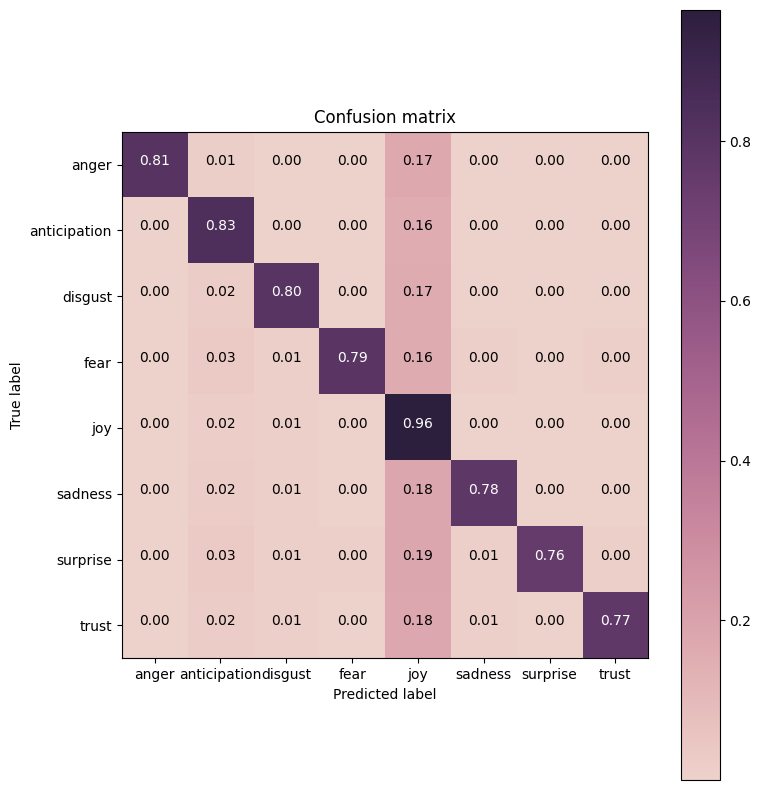

In [23]:
cm = confusion_matrix(y_true=y_train, y_pred=y_train_pred) 
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

# plot your confusion matrix
my_tags = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
plot_confusion_matrix(cm_normalized, classes=my_tags, title='Confusion matrix')

---
**kmeans**

In [30]:
from sklearn.cluster import KMeans

# we have to decide how many cluster (k) we want
k = 2

# k-means model
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(X_train)

# cluster result
cluster_result = kmeans_model.labels_

target_list = list(set(y_train))

# show
for i in range(len(target_list)):
    print('word: {} \t\t cluster: {}'.format(target_list[i], cluster_result[i]))

word: sadness 		 cluster: 1
word: anger 		 cluster: 0
word: anticipation 		 cluster: 0
word: trust 		 cluster: 0
word: surprise 		 cluster: 0
word: joy 		 cluster: 0
word: disgust 		 cluster: 0
word: fear 		 cluster: 1


In [68]:
from sklearn.cluster import KMeans

k = len(target_list)  
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train)

KMeans(random_state=42)

In [64]:
from collections import Counter
import numpy as np

# Assign clusters
cluster_labels = kmeans.labels_

# Map clusters to actual labels
cluster_to_label = {}
for cluster in range(k):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    print(cluster_indices)
    true_labels = [y_train[i] for i in cluster_indices]
    most_common_label = Counter(true_labels).most_common(1)[0][0]
    cluster_to_label[cluster] = most_common_label
    print(most_common_label)

[      1      31      68 ... 1455524 1455557 1455561]
joy
[     10      11      14 ... 1455556 1455558 1455562]
joy
[      0       7       8 ... 1455531 1455543 1455548]
joy
[      4       5       9 ... 1455555 1455559 1455560]
joy
[     30      74     184 ... 1455497 1455511 1455512]
joy
[      2      32      42 ... 1455509 1455514 1455537]
joy
[      6      21      25 ... 1455517 1455536 1455542]
joy
[      3      93     110 ... 1455492 1455516 1455554]
joy


In [69]:
from collections import Counter
import numpy as np

# Assume `labels` contains the true labels for the dataset
label_counts = Counter(y_train)  # Overall label distribution
total_labels = len(y_train)

# Compute prior probabilities
label_priors = {label: count / total_labels for label, count in label_counts.items()}

# Map clusters to labels
cluster_to_label = {}
for cluster in range(k):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    true_labels = [y_train[i] for i in cluster_indices]

    # Adjust label counts by their priors
    adjusted_counts = {label: count / label_priors[label] for label, count in Counter(true_labels).items()}
    most_common_label = max(adjusted_counts, key=adjusted_counts.get)
    cluster_to_label[cluster] = most_common_label

print("Cluster to Label Mapping:", cluster_to_label)

Cluster to Label Mapping: {0: 'anger', 1: 'anger', 2: 'anger', 3: 'anticipation', 4: 'anger', 5: 'disgust', 6: 'disgust', 7: 'disgust'}


The clustering is unbalanced. Check the number of labels. 

<BarContainer object of 8 artists>

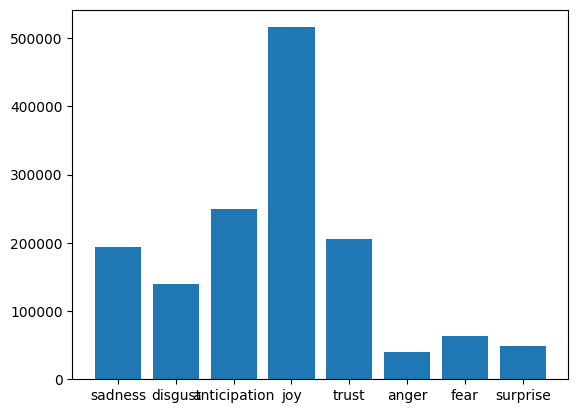

In [81]:
plt.bar(label_counts.keys(), label_counts.values())

Too many data from the 'joy' label. I will try to use a two-step classification to seaprate joy/non-joy first, then separate the rest.

In [91]:
# transform the y_train labels first
y_train_binary = ['joy' if i == 'joy' else 'non-joy' for i in y_train]
y_train_binary[:10]

['non-joy',
 'non-joy',
 'non-joy',
 'joy',
 'non-joy',
 'joy',
 'non-joy',
 'non-joy',
 'non-joy',
 'non-joy']

In [92]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train_binary)

## predict!
y_train_pred = DT_model.predict(X_train)

## so we get the pred result
y_train_pred[:10]

array(['non-joy', 'non-joy', 'joy', 'joy', 'non-joy', 'non-joy',
       'non-joy', 'non-joy', 'non-joy', 'non-joy'], dtype='<U7')

In [93]:
## accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train_binary, y_pred=y_train_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))

training accuracy: 0.92


In [94]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_train_binary, y_pred=y_train_pred))

              precision    recall  f1-score   support

         joy       0.94      0.82      0.88    516017
     non-joy       0.91      0.97      0.94    939546

    accuracy                           0.92   1455563
   macro avg       0.93      0.90      0.91   1455563
weighted avg       0.92      0.92      0.92   1455563



In [97]:
Counter(y_train_pred)

Counter({'non-joy': 1005023, 'joy': 450540})

In [99]:
import numpy as np

non_joy_indices = [index for index, label in enumerate(y_train_pred) if label == 'non-joy']
non_joy_labels = y_train[non_joy_indices]
non_joy_data = X_train[non_joy_indices]
print(len(non_joy_indices)) # 1005023

1005023


In [120]:
Counter(non_joy_labels)

Counter({'anticipation': 242064,
         'trust': 199922,
         'sadness': 188173,
         'disgust': 135261,
         'joy': 91103,
         'fear': 62254,
         'surprise': 47416,
         'anger': 38830})

Perform k-means classification with the non-joy data. 

In [122]:
from sklearn.cluster import KMeans

k = len(target_list) - 1
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(non_joy_data)

KMeans(n_clusters=7, random_state=42)

In [140]:
# Assign clusters
cluster_labels = kmeans.labels_

# Map clusters to actual labels
cluster_to_label = {}
how_many_labels = []
for cluster in range(k):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    print(cluster_indices)
    true_labels = [y_train[i] for i in cluster_indices]
    most_common_label = Counter(true_labels)
    cluster_to_label[cluster] = most_common_label
    print(most_common_label)

[      4      13      17 ... 1004945 1004995 1005011]
Counter({'joy': 33199, 'anticipation': 16174, 'trust': 13344, 'sadness': 12499, 'disgust': 8832, 'fear': 4132, 'surprise': 3158, 'anger': 2640})
[     20      26      31 ... 1004955 1004977 1005007]
Counter({'joy': 28587, 'anticipation': 13889, 'trust': 11481, 'sadness': 10643, 'disgust': 7856, 'fear': 3564, 'surprise': 2826, 'anger': 2259})
[      0       5       6 ... 1005006 1005012 1005015]
Counter({'joy': 53513, 'anticipation': 25926, 'trust': 21377, 'sadness': 20149, 'disgust': 14809, 'fear': 6679, 'surprise': 4966, 'anger': 4096})
[      1       2       3 ... 1005020 1005021 1005022]
Counter({'joy': 195945, 'anticipation': 94214, 'trust': 77833, 'sadness': 73416, 'disgust': 52347, 'fear': 24102, 'surprise': 18404, 'anger': 15068})
[    565     813     938 ... 1004959 1004970 1004976]
Counter({'joy': 1753, 'anticipation': 809, 'trust': 692, 'sadness': 666, 'disgust': 417, 'fear': 200, 'surprise': 162, 'anger': 133})
[     36  

The distribution of each label in all clusters are extremely similar, giving up on K-means. 

---
**Support Vector Machine**

In [119]:
from collections import Counter
import numpy as np

# Assume `labels` contains the true labels for the dataset
label_counts = Counter(non_joy_labels)  # Overall label distribution
total_labels = len(non_joy_labels)

# Compute prior probabilities
label_priors = {label: count / total_labels for label, count in label_counts.items()}

# Map clusters to labels
cluster_to_label = {}
for cluster in range(k):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    true_labels = [y_train[i] for i in cluster_indices]

    # Adjust label counts by their priors
    adjusted_counts = {label: count / label_priors[label] for label, count in Counter(true_labels).items()}
    most_common_label = max(adjusted_counts, key=adjusted_counts.get)
    cluster_to_label[cluster] = most_common_label

print("Cluster to Label Mapping:", cluster_to_label)

Cluster to Label Mapping: {0: 'joy', 1: 'joy', 2: 'joy', 3: 'joy', 4: 'joy', 5: 'joy', 6: 'joy'}


In [ ]:
# unique, counts = np.unique(cluster_labels, return_counts=True)
# cluster_counts = dict(zip(cluster_to_label.values(), counts))

# print("Cluster Counts:", cluster_counts)

Cluster Counts: {'anger': 29278, 'anticipation': 513954, 'disgust': 49207}


In [53]:
def predict(new_word_vector):
    cluster = kmeans.predict(new_word_vector)[0]
    return cluster_to_label[cluster]

y_train_pred = []
for i in range(len(y_train)):
    y_train_pred.append(predict(X_train[i]))

In [48]:
cm = confusion_matrix(y_true=y_train, y_pred=y_train_pred) 
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

# plot your confusion matrix
my_tags = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
plot_confusion_matrix(cm_normalized, classes=my_tags, title='Confusion matrix')

InvalidParameterError: The 'y_pred' parameter of confusion_matrix must be an array-like. Got 'joy' instead.

---
stupid prediction method

In [4]:
import numpy as np

In [6]:
all_joy_pred_df = pd.DataFrame({
    "id": dat_id[dat_id['identification']=='test']['tweet_id'],
    "emotion": 'joy'
})
all_joy_pred_df.to_csv('all_joy_pred.csv', index=False)